In [28]:
from statsforecast import StatsForecast
from yfinance import Ticker

import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    WindowAverage,
    AutoARIMA,
    AutoETS
)

from utilsforecast.losses import mae, rmse
from utilsforecast.evaluation import evaluate


os.environ['NIXTLA_ID_AS_COL'] = '1'
plt.rcParams['axes.grid'] = True

Task:

You need to forecast closing prices for every working day between 10th and 18th of February; you may use actual values up to the 9th of February. Your submission has to have both point forecasts and 95% prediction intervals. 
Try every forecasting method that we discussed this week and select one that you think is the best - you need to provide just one final forecast. 


Your submission should be a reproducible notebook where you get and plot the data, try different forecasting methods, evaluate and compare forecasts using suitable methods and metrics, and choose and plot your final forecast.

#### OHLCV of MSFT

- `open`  : price at market open
- `high`  : highest price during the day
- `low`   : lowest price during the day
- `close` : price at market close
- `volume`: number of shares traded

In [29]:
tick = 'MSFT'

# downloading two years of historical price data of Microsoft Corporation - MSFT
df_raw = Ticker(tick).history(period="2y", auto_adjust=True)
df_raw.tail(15)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2026-01-21 00:00:00-05:00,452.600006,452.690002,438.679993,444.109985,37980500,0.0,0.0
2026-01-22 00:00:00-05:00,447.619995,452.839996,444.700012,451.140015,25349400,0.0,0.0
2026-01-23 00:00:00-05:00,451.869995,471.100006,450.529999,465.950012,38000200,0.0,0.0
2026-01-26 00:00:00-05:00,465.309998,474.250000,462.000000,470.279999,29291200,0.0,0.0
2026-01-27 00:00:00-05:00,473.700012,482.869995,473.160004,480.579987,29213900,0.0,0.0
2026-01-28 00:00:00-05:00,483.209991,483.739990,478.000000,481.630005,36875400,0.0,0.0
2026-01-29 00:00:00-05:00,439.989990,442.500000,421.019989,433.500000,128855300,0.0,0.0
2026-01-30 00:00:00-05:00,439.170013,439.600006,426.450012,430.290009,58566800,0.0,0.0
2026-02-02 00:00:00-05:00,430.239990,430.739990,422.250000,423.369995,42219900,0.0,0.0


In [30]:
print("Start date:", df_raw.index.min())
print("End date:  ", df_raw.index.max())

Start date: 2024-02-12 00:00:00-05:00
End date:   2026-02-10 00:00:00-05:00


In [31]:
# use up to 9
start_date = '2024-02-08'
end_date = '2026-02-09'

In [32]:
df = pd.DataFrame({'unique_id': 1.0, 'ds': df_raw.index.tz_localize(None), 'y': df_raw.Close.values})
df = df[(df.ds >= pd.to_datetime(start_date)) & (df.ds <= pd.to_datetime(end_date)) ]
df.ds = range(df.shape[0])

df.tail()

,unique_id,ds,y
495,1.0,495,411.209991
496,1.0,496,414.190002
497,1.0,497,393.670013
498,1.0,498,401.140015
499,1.0,499,413.600006


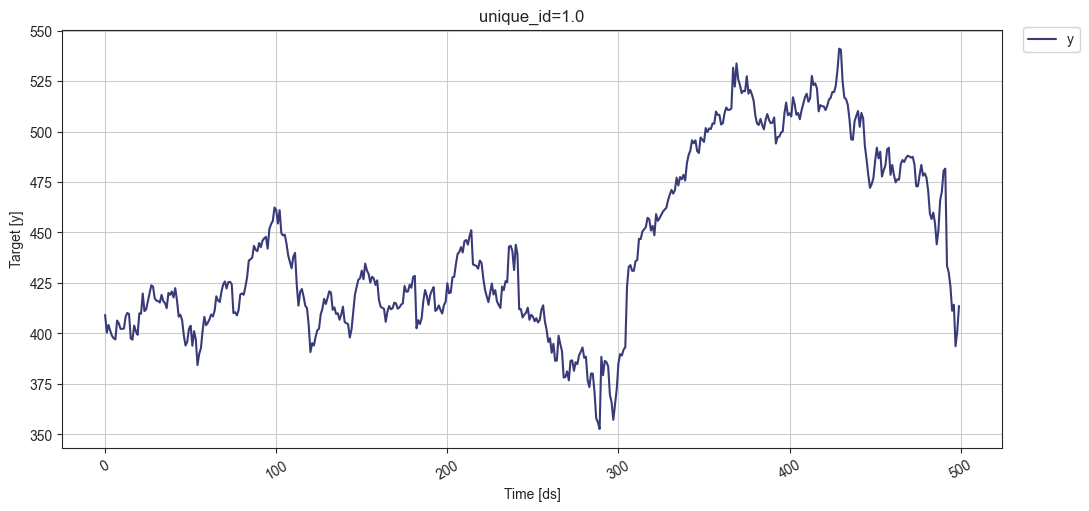

In [33]:
f = StatsForecast.plot(df)
f.set_figwidth(10)
f.set_figheight(5)
f

#### Simple Findings
- non-stationary (random walk)
- structural break (300 & 500)
- no clear seasonality

#Just making sure with statistical tests for non-stationary data with: adf and kpss

In [34]:
adf_result = adfuller(df['y'])
adf_result

(np.float64(-1.6855118750245166),
 np.float64(0.4385922285514146),
 0,
 499,
 {'1%': np.float64(-3.4435228622952065),
  '5%': np.float64(-2.867349510566146),
  '10%': np.float64(-2.569864247011056)},
 np.float64(3172.6021125738253))

In [35]:
if adf_result[1] > 0.05:
    print("ADF: Failed to reject null hypothesis -> The series is non-stationary")

ADF: Failed to reject null hypothesis -> The series is non-stationary


In [36]:
kpss_result = kpss(df['y'])
kpss_result

/var/folders/d7/5xjp058538n1_2xf1mtj_bwr0000gn/T/ipykernel_13949/3429579584.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df['y'])


(np.float64(2.0711004674726756),
 np.float64(0.01),
 12,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [37]:
if kpss_result[1] < 0.05:
    print(f'KPSS: Null hypothesis rejected -> series is non-stationary')

KPSS: Null hypothesis rejected -> series is non-stationary


#### Cross Validation Baselines


Train ------------------------| Forecast 5\
Train ---------------------------| Forecast 5\
Train -------------------------------| Forecast 5\
Train ----------------------------------| Forecast 5\
Train -------------------------------------| Forecast 5


In [38]:
sf = StatsForecast(
    models=[
        HistoricAverage(alias="HistoricAverage"),
        Naive(alias="Naive"),
        RandomWalkWithDrift(alias="RWD"),
        WindowAverage(window_size=2, alias="WindowAverage2"),
        WindowAverage(window_size=7, alias="WindowAverage7"),
    ],
    freq=1
)

In [39]:
# rolling-origin (time-series cross validation)
# h=5            (5 days ahead forecast)
# step_size=5    (move training window 5days each iteration)
# n_windows=5    (5 iterations)
cv_df = sf.cross_validation(
    df=df,
    h=5,
    step_size=5,
    n_windows=5
)

cv_df.head(25)

,unique_id,ds,cutoff,y,HistoricAverage,Naive,RWD,WindowAverage2,WindowAverage7
0,1.0,475,474,472.850006,442.190482,472.940002,473.074561,478.279999,484.817143
1,1.0,476,474,478.510010,442.190482,472.940002,473.209119,478.279999,484.817143
2,1.0,477,474,483.470001,442.190482,472.940002,473.343677,478.279999,484.817143
3,1.0,478,474,478.109985,442.190482,472.940002,473.478235,478.279999,484.817143
4,1.0,479,474,479.279999,442.190482,472.940002,473.612793,478.279999,484.817143
5,1.0,480,479,477.179993,442.568123,479.279999,479.426388,478.694992,478.397143
6,1.0,481,479,470.670013,442.568123,479.279999,479.572778,478.694992,478.397143
7,1.0,482,479,459.380005,442.568123,479.279999,479.719167,478.694992,478.397143
8,1.0,483,479,456.660004,442.568123,479.279999,479.865557,478.694992,478.397143
9,1.0,484,479,459.859985,442.568123,479.279999,480.011946,478.694992,478.397143


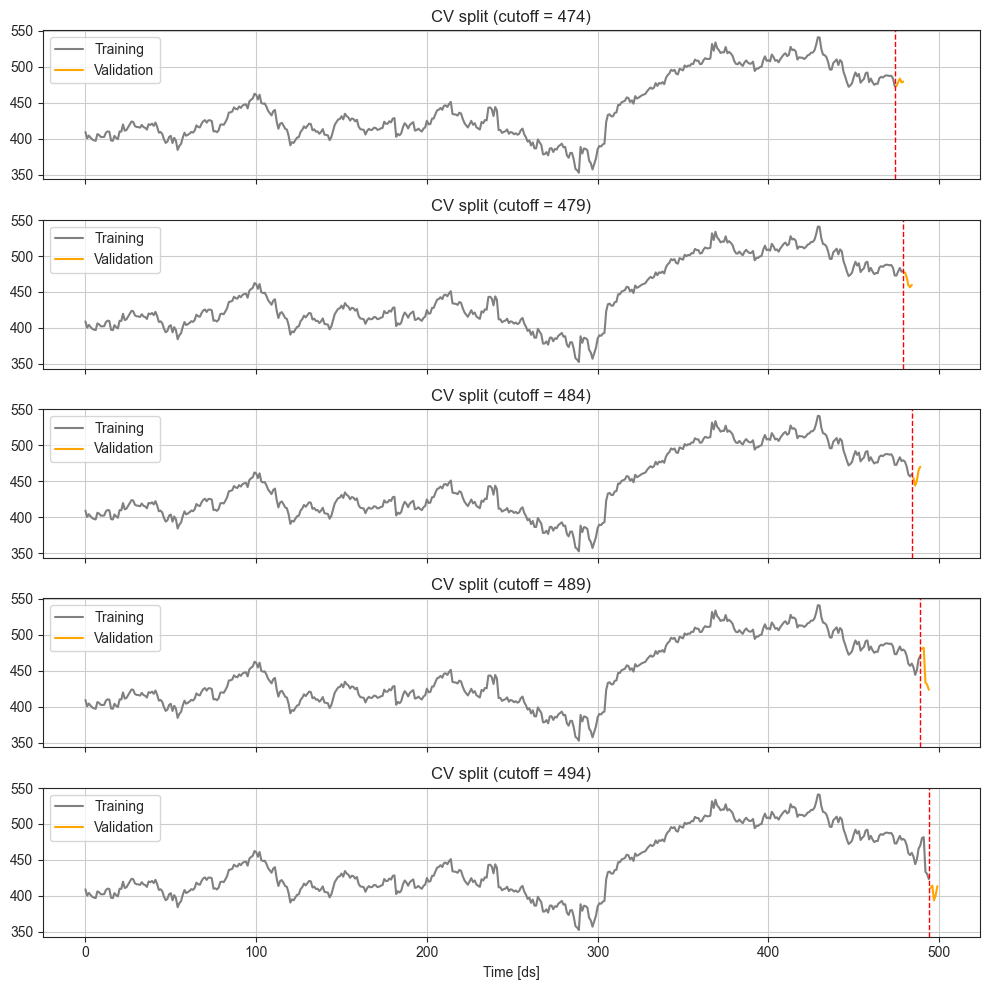

In [ ]:
cutoffs = cv_df['cutoff'].unique()

fig, axes = plt.subplots(
    nrows=len(cutoffs),
    figsize=(10, 2 * len(cutoffs)),
    sharex=True
)

if len(cutoffs) == 1:
    axes = [axes]

for ax, cutoff in zip(axes, cutoffs):
    # training data: ds <= cutoff
    train = df[df['ds'] <= cutoff]
    # validation data: ds > cutoff & ds <= cutoff + h
    val = df[(df['ds'] > cutoff) & (df['ds'] <= cutoff + 5)]

    ax.plot(train['ds'], train['y'], color='gray', label='Training')
    ax.plot(val['ds'], val['y'], color='orange', label='Validation')

    ax.axvline(cutoff, color='red', linestyle='--', linewidth=1)
    ax.set_title(f'CV split (cutoff = {cutoff})')
    ax.legend(loc='upper left')

plt.xlabel('Time [ds]')
plt.tight_layout()
plt.show()


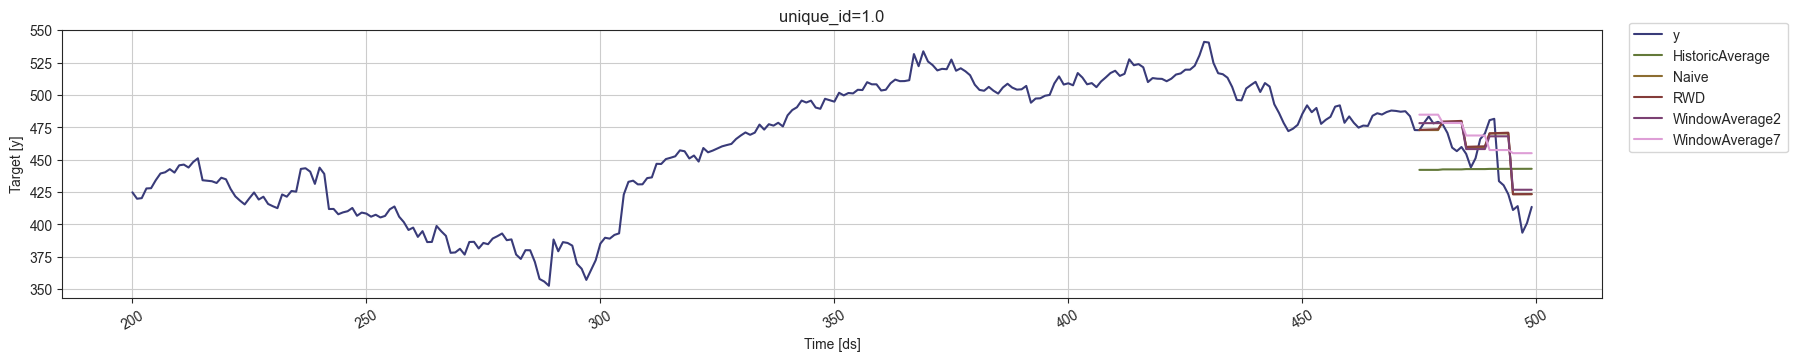

In [52]:
StatsForecast.plot(
    df[200:],
    cv_df.drop(columns=["cutoff", "y"])
)

In [42]:
eval_res = evaluate(cv_df, metrics=[mae, rmse], models=['HistoricAverage', 'Naive', 'RWD', 'WindowAverage2', 'WindowAverage7'])
eval_res

,unique_id,cutoff,metric,HistoricAverage,Naive,RWD,WindowAverage2,WindowAverage7
0,1.0,474,mae,36.253518,5.539996,5.190145,2.404004,6.373143
1,1.0,479,mae,22.181877,14.529999,14.969167,13.944992,13.647143
2,1.0,484,mae,14.403198,9.264001,9.201150,8.944003,12.152570
3,1.0,489,mae,23.598752,29.065997,29.290981,28.632999,26.510569
4,1.0,494,mae,36.251770,16.607990,16.694288,20.067996,48.323710
5,1.0,474,rmse,36.411416,6.462789,6.070628,3.391246,7.217382
6,1.0,479,rmse,23.528395,16.512739,16.985795,16.000390,15.741480
7,1.0,484,rmse,17.321455,9.982796,9.960568,9.680097,15.020665
8,1.0,489,rmse,26.629099,32.825077,33.185062,31.524834,26.819402
9,1.0,494,rmse,37.136718,18.459965,18.540256,21.625667,48.991080


Zoom In Naive vs WindowAverage2

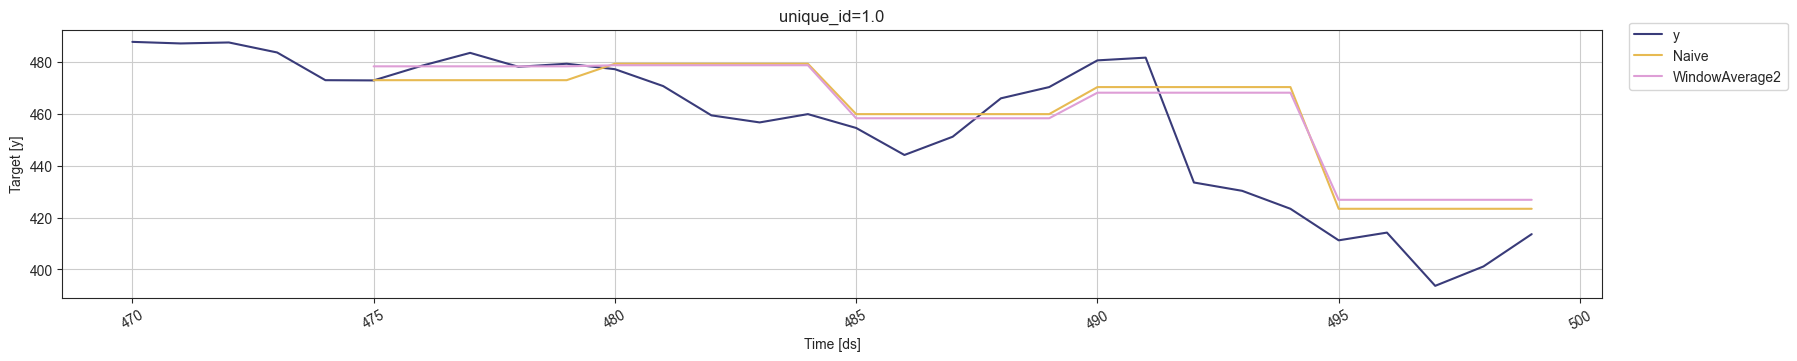

In [43]:
StatsForecast.plot(
    df[470:],
    cv_df[['unique_id', 'ds', 'Naive', 'WindowAverage2']]
)

> Naive seems the most stable one in here in all 5 cut offs

In [44]:
sf = StatsForecast(models=[Naive()], freq=1)
sf.fit(df)

# point forecasting with naive baseline
# and 95% prediction intervals
naive_f = sf.predict(h=8, level=[95])
naive_f

,unique_id,ds,Naive,Naive-lo-95,Naive-hi-95
0,1.0,500,413.600006,400.879539,426.320473
1,1.0,501,413.600006,395.610550,431.589463
2,1.0,502,413.600006,391.567511,435.632501
3,1.0,503,413.600006,388.159073,439.040940
4,1.0,504,413.600006,385.156178,442.043834
5,1.0,505,413.600006,382.441353,444.758659
6,1.0,506,413.600006,379.944815,447.255198
7,1.0,507,413.600006,377.621093,449.578919


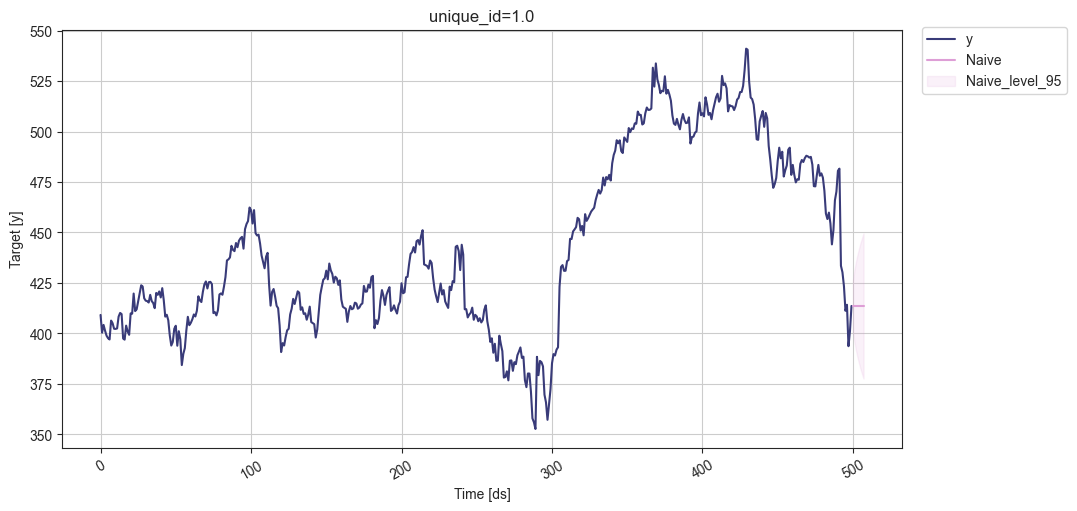

In [45]:
f = sf.plot(df, naive_f, models=['Naive'], level=[95])
f.set_figwidth(9)
f.set_figheight(5)
f

#Residual Plot Analysis

In [46]:
res = df.copy()

# Naive fitted values = lag-1
res['fitted'] = res['y'].shift(1)
res['residuals'] = res['y'] - res['fitted']

# drop first NaN
res = res.dropna()

res.tail()

,unique_id,ds,y,fitted,residuals
495,1.0,495,411.209991,423.369995,-12.160004
496,1.0,496,414.190002,411.209991,2.980011
497,1.0,497,393.670013,414.190002,-20.519989
498,1.0,498,401.140015,393.670013,7.470001
499,1.0,499,413.600006,401.140015,12.459991


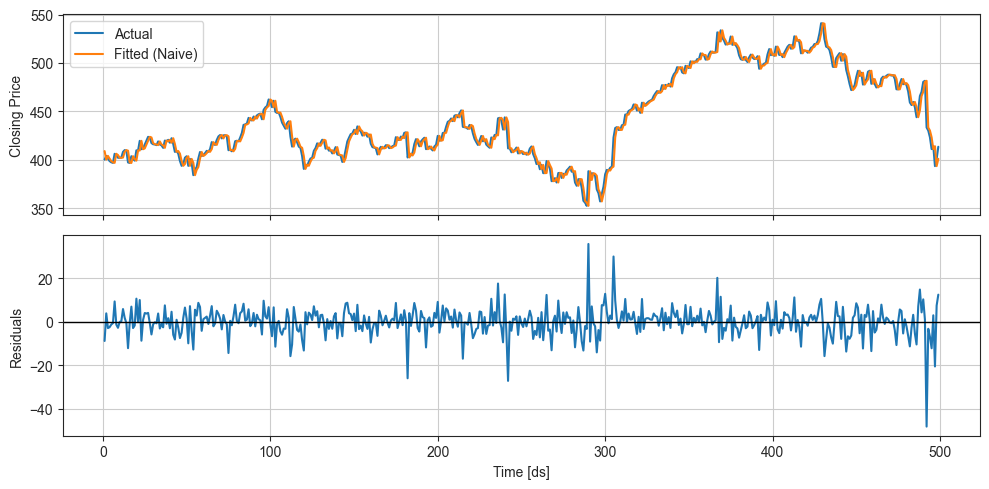

In [47]:
sns.set_style("ticks", {'axes.grid': True})

fig, axs = plt.subplots(nrows=2, figsize=(10, 5), sharex=True)

sns.lineplot(x='ds', y='y', data=res, label='Actual', ax=axs[0])
sns.lineplot(x='ds', y='fitted', data=res, label='Fitted (Naive)', ax=axs[0])
axs[0].set_ylabel('Closing Price')
axs[0].legend()

sns.lineplot(x='ds', y='residuals', data=res, ax=axs[1])
axs[1].axhline(0, color='black', linewidth=1)
axs[1].set_ylabel('Residuals')
axs[1].set_xlabel('Time [ds]')

plt.tight_layout()
plt.show()

In [48]:
sf = StatsForecast(
    models=[
        Naive(alias="Naive"),
        WindowAverage(window_size=2, alias="WindowAverage2"),
        AutoARIMA(alias="AutoARIMA"),
        AutoETS(alias="AutoETS"),
    ],
    freq=1
)

cv_df_advanced = sf.cross_validation(
    df=df,
    h=5,
    step_size=5,
    n_windows=5
)

In [49]:
eval_advanced = evaluate(
    cv_df_advanced,
    metrics=[mae, rmse],
    models=["Naive", "WindowAverage2", "AutoARIMA", "AutoETS"]
)

eval_advanced

,unique_id,cutoff,metric,Naive,WindowAverage2,AutoARIMA,AutoETS
0,1.0,474,mae,5.539996,2.404004,5.539996,5.436250
1,1.0,479,mae,14.529999,13.944992,14.529999,14.512533
2,1.0,484,mae,9.264001,8.944003,9.264001,9.257751
3,1.0,489,mae,29.065997,28.632999,29.065997,29.063646
4,1.0,494,mae,16.607990,20.067996,16.607990,16.608682
5,1.0,474,rmse,6.462789,3.391246,6.462789,6.316181
6,1.0,479,rmse,16.512739,16.000390,16.512739,16.497373
7,1.0,484,rmse,9.982796,9.680097,9.982796,9.974514
8,1.0,489,rmse,32.825077,31.524834,32.825077,32.817769
9,1.0,494,rmse,18.459965,21.625667,18.459965,18.460588


AutoARIMA automatically selected an <mark>ARIMA(0,1,0)</mark> model, which is equivalent to the Naive random-walk model.\
This confirms that no additional autoregressive or moving-average structure is present in the series beyond a unit-root process.

AutoETS selected an <mark>ETS(A,N,N)</mark> specification, indicating additive errors with no trend or seasonality.

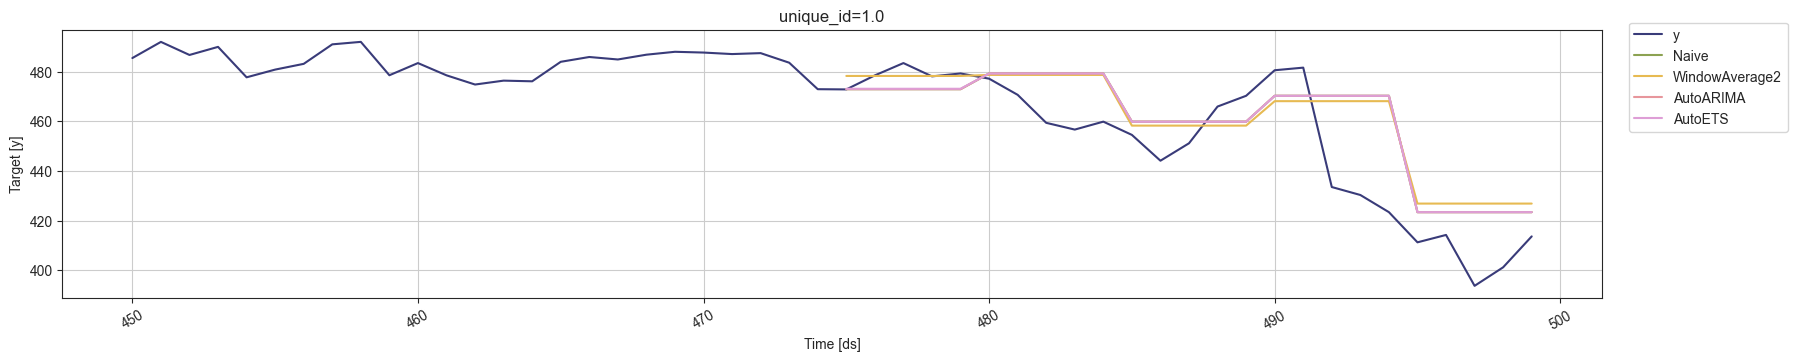

In [50]:
StatsForecast.plot(
    df[450:],
    cv_df_advanced.drop(columns=["cutoff", "y"])
)

#### Model Selection Summary for MSFT Closing Prices

> The `Naive` model turns out to be the most reliable and safest choice for forecasting MSFT closing prices.

Statistical tests support a random-walk behavior
- The `ADF` test fails to reject the null hypothesis, suggesting the presence of a unit root.
- The `KPSS` test rejects the null hypothesis of stationarity.

Model comparison results
- `AutoARIMA` selected an ARIMA(0,1,0) -> naive
- `AutoETS` selected ETS(A,N,N) -> indicating addictive errors
- `WindowAverage2` performed well during calm market periods but degraded significantly under large price shocks

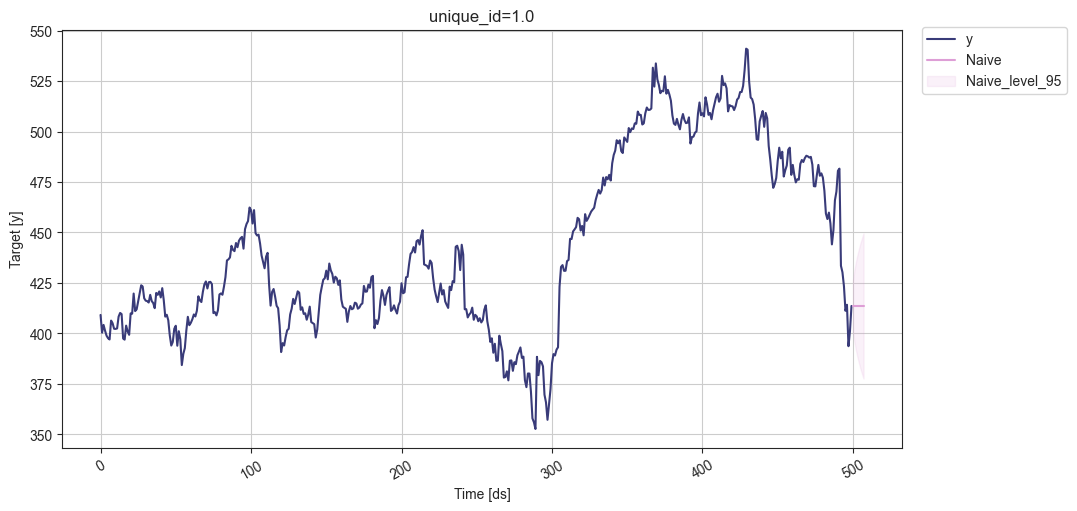

In [51]:
sf = StatsForecast(models=[Naive()], freq=1)
sf.fit(df)

# point forecasting with naive baseline
# and 95% prediction intervals
naive_f = sf.predict(h=8, level=[95])
naive_f

f = sf.plot(df, naive_f, models=['Naive'], level=[95])
f.set_figwidth(9)
f.set_figheight(5)
f